<a href="https://colab.research.google.com/github/jeetThakkar10/Quora-Case-Study/blob/main/Case_Study_1_1_(Quora).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quora Question Pairs

##  Description

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 

### Problem Statement

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

### Constraints

1. Cost of misclassification can be high. 
2. latency is not an issue.
3. Having a probablility value for 2 questions to be duplicate will help because we can set a threshold. 
4. Interpretability is partially important.


### Data overvieww

- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

### Performance Metrics


- log-loss is the performance metric that we must use to evaluate our model.
- Binary Confusion matrix. 

### Note:
The types of questions can change over time. If we had time data of questions, we would have sorted those questions based on time. Since we cannot do this, the best way for now will be randomly splitting data into train and test. 


## Exploratory Data Analysis


In [1]:
!pip install Distance

     |████████████████████████████████| 180 kB 5.1 MB/s 
  Created wheel for Distance: filename=Distance-0.1.3-py3-none-any.whl size=16276 sha256=eca1826a26aee51bc7e5d367d274397f3336dcb433cee620b1909b74d1dbcd92
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built Distance


In [2]:
!pip install fuzzywuzzy

In [3]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from difflib import SequenceMatcher
from fuzzywuzzy import fuzz

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Readig data and basic analysis

In [5]:
# from google.colab import files
# import io
# train_csv = files.upload()

In [6]:
# df = pd.read_csv(io.BytesIO(train_csv['train.csv']))
df = pd.read_csv(r'/content/drive/MyDrive/ML Datasets/CaseStudy1 - Quora/train.csv')
print(df.shape)

(404290, 6)


In [7]:
df.head(100)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
95,95,191,192,How does 3D printing work?,How do 3D printing work?,1
96,96,193,194,What was it like to attend Caltech with Jeremy...,Who are some notable folks who attended Caltech?,0
97,97,195,196,Why did harry become a horcrux?,What is a Horcrux?,0
98,98,197,198,What are the best associate product manager (A...,What are the general requirement to become a P...,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


- id is just like a simple id <br>
- q id 1 and 2 are the ids of questions <br>
- is_duplicate is the class label (0 or 1) which means if they are similar or not. (0= dissimilar and 1 = similar)



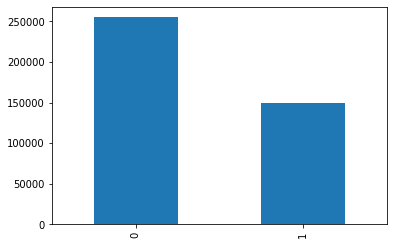

In [9]:
df['is_duplicate'].value_counts().plot(kind='bar')

In [10]:
print("Total number of question pairs in the dataset for training = {} ".format(len(df)))

Total number of question pairs in the dataset for training = 404290 


In [11]:
print("Question pairs that are not similar (is_duplicate=0) = {}% ".format(round((1-df['is_duplicate'].mean())*100 , 2)))
print("Question pairs that are similar (is_duplicate=1) = {}% ".format(round(df['is_duplicate'].mean()*100 , 2)))

Question pairs that are not similar (is_duplicate=0) = 63.08% 
Question pairs that are similar (is_duplicate=1) = 36.92% 


In [12]:
qids = pd.Series(df["qid1"].tolist() + df["qid2"].tolist())
# # Merging the QuestionIDs into one pandas Serires by converting them into a list
unique_qs = len(np.unique(qids))    # Unique questions
print("~> Number of unique questions = {}".format(unique_qs))
qs_morethan_onetime = np.sum(qids.value_counts() > 1 )
print("Number of questions that appear more than once = {}".format(qs_morethan_onetime))
print("Maximum times a single question is repeated = {}".format(max(qids.value_counts())))


~> Number of unique questions = 537933
Number of questions that appear more than once = 111780
Maximum times a single question is repeated = 157


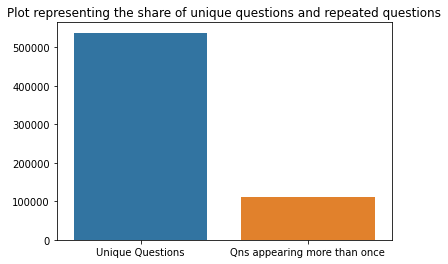

In [13]:
# plot representing the share of unique questions and repeated questions
sns.barplot(x=["Unique Questions", "Qns appearing more than once"], y=[unique_qs, qs_morethan_onetime])
plt.title("Plot representing the share of unique questions and repeated questions")
plt.show()

Text(0.5, 1.0, 'log histogram of question frequency ')

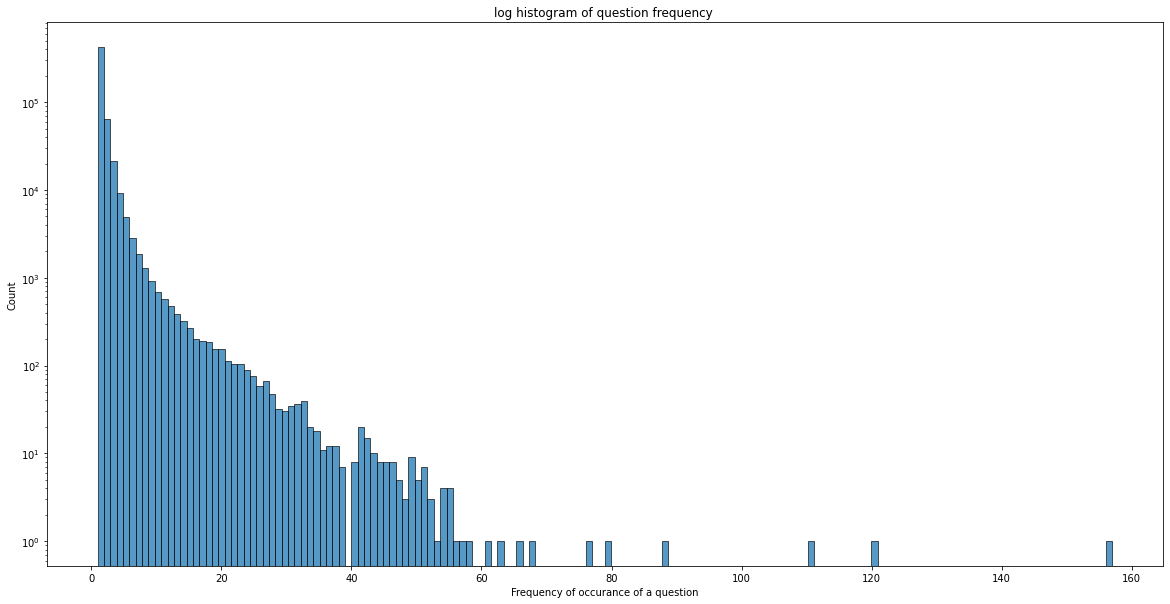

In [14]:
plt.figure(figsize=(20, 10))
sns.histplot(qids.value_counts(), bins=160)
plt.yscale('log')
plt.xlabel("Frequency of occurance of a question")
plt.ylabel("Count")
plt.title("log histogram of question frequency ")

### Handling null values

In [15]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [16]:
# Filling null values with ''
df = df.fillna('')

### Basic Feature Extraction (Before Cleaning)

**We will construct some baisc features out of the currently available features**
- freq_qid1 = Frequency of qid1's<br>
-freq_qid2 = Frequency of qid2's<br>
-q1len = Length of question 1<br>
-q2len = Length of question 2<br>
-q1_n_words = Number of words in q1<br>
-q2_n_words = Number of words in q2<br>
-words_common = NUmber of common words in q1 and q2<br>
-words_total = Number of total words in q1 and q2<br>
-word_share = words_common/words_total<br>
-freq_q1 + freq_q2 = Sum of frequencies of q1 and q2<br>
-freq_q1 - freq_q2 = Absolute difference in frequencies of q1 and q2


In [17]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['q1_len_words'] = df['question1'].apply(lambda x : len(x.split(" ")))
df['q2_len_words'] = df['question2'].apply(lambda x : len(x.split(" ")))

def normalized_word_common (row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" ")))
    return(len( w1 & w2))
df['words_common'] = df.apply(normalized_word_common, axis=1)

def normalized_word_total(row):
    w1 = set(map(lambda word :word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word :word.lower().strip(), row['question1'].split(" ")))
    return(1.0* len(w1)*len(w2))
df['words_total'] = df.apply(normalized_word_total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" ")))
    return(len(w1 & w2)/(len(w1)+len(w2)))
df['word_share'] = df.apply(normalized_word_share, axis=1)
df.head()

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
    



### Feature: Word Share


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



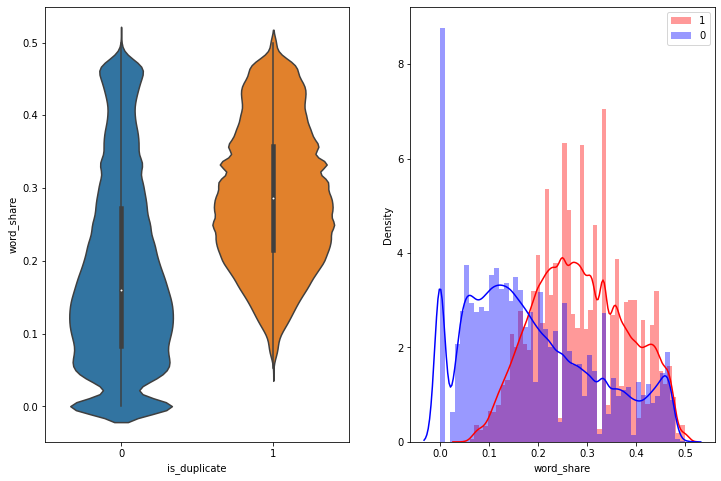

In [18]:
plt.figure(figsize = (12,8))

plt.subplot(1,2,1)
sns.violinplot(x=df['is_duplicate'], y=df['word_share'], data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_share'][0:], label="1", color='red')
sns.distplot(df[df['is_duplicate']==0.0]['word_share'][0:], label="0", color='blue')
plt.legend()
plt.show()

### Feature Word_common

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



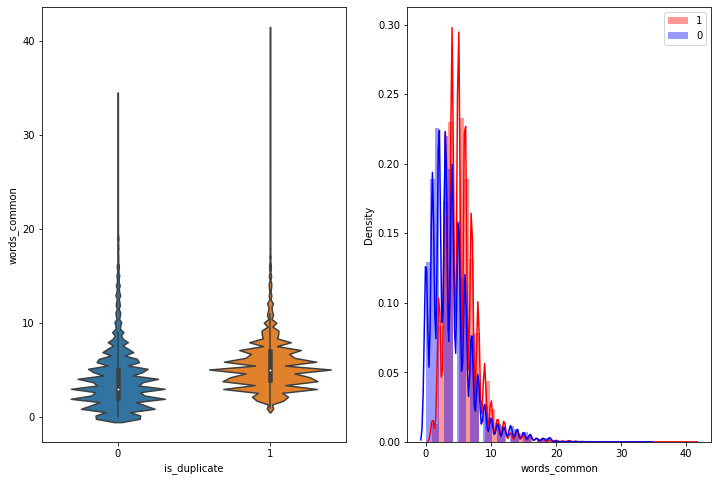

In [19]:
plt.figure(figsize = (12,8))

plt.subplot(1,2,1)
sns.violinplot(x=df["is_duplicate"], y=df['words_common'])

plt.subplot(1,2,2)
sns.distplot(df[df["is_duplicate"]==1]['words_common'][0:], color='red', label="1")
sns.distplot(df[df["is_duplicate"]==0]['words_common'][0:], color = 'blue', label='0')
plt.legend()
plt.show()

# Advanced Feature Extraction

###  Basic preprocessing of text
- Stop word removal(pp4)<br>
- Removing punctuation marks (pp2)<br>
- Removing html tags (pp1)<br>
- Stemming(pp5)<br>
- Expanding contractions(pp3), etc

In [20]:
import nltk
# nltk.download('stopwords')
# Stop_Words = stopwords.words('english')
# def preprocessing(row):
#     q1_without_sw = map(lambda x : ' '.join([word for word in x.split() if word not in (Stop_Words)]), row)
#     # q2_without_sw = map(lambda x : ' '.join([word for word in x.split() if word not in (Stop_Words)]), row['question2'])
#     return(q1_without_sw)
# df['q1_without_sw']= df['question1'].apply(preprocessing)
# df.head()


In [21]:

CLEANR = re.compile('<.*?>')    # Removing HTML Tags   
tokenizer = RegexpTokenizer(r'\w+')    # Removing puntuations
nltk.download('stopwords')    # Downloading Stop Words
Stop_Words = stopwords.words('english')
snow_stemmer = SnowballStemmer(language='english')    # Initializing SnowBall Stemmer for stemming

def preprocessing(row):
  # print(type(row))
  row = str(row).lower()    # Converting everything into lower case
  pp1_1 = re.sub(CLEANR, '', row)   # Removing HTML Tags
  pp2_1 = tokenizer.tokenize(pp1_1)    # Removing punctuations
  pp2_1 = " ".join(pp2_1)    # The above line returns a list. Converting it into a string

  pp3_1 = pp2_1.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                      .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                      .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                      .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                      .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                      .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                      .replace("€", " euro ").replace("'ll", " will")

  # pp4_1 = "".join([word for word in pp3_1 if word not in Stop_Words])
  # pp4_1 = pp3_1.split()
  # pp4_1 = " ".join([word for word in pp4_1 if word not in Stop_Words])


  pp5_1 = pp3_1.split()
  for i in range(len(pp5_1)):
    pp5_1[i] = snow_stemmer.stem(pp5_1[i])

  pp5_1 = " ".join([word for word in pp5_1 ])
  return pp5_1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Advanced Feature Extraction


**Definition :**
> **Token :** Tokenization is the process wherein a string is broken into parts. Each element of it is called a token. <br>
> **Stop Words :** Stop words as per NLTK. <br>
> **Word :** A token that is not a stopword. <br>

**Features :**
> **cwc_min** : Ratio of common word count to minimum word count of q1 and q2.<br>
> **cwc_max** : Ratio of common word count to maximum word count of q1 and q2.<br>
> **csc_min :** Ratio of common StopWord count to minimum stro word count of q1 and q2<br>
> **csc_max:** Ratio of common StopWords count to maximum stop word count of q1 and q2. <br>
> **ctc_min:** Ratio of common token count to minimum length of token count of q1 and q2. <br>
> **ctc_max:** Ratio of common token count to maximum length of token count of q1 and q2. <br>
> **last_word_eq:** Check if last word of both the questions is equal or not. <br>
> **first_word_eq:** Check if first word of both the questions is equal or not. <br>
> **abs_len_diff: ** Absolute length difference. <br>
> **mean_len:** Mean length of q1 and q2. <br>

> **fuzz_ratio__ :**  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>

>**fuzz_partial_ratio:**  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>


> **token_sort_ratio:** https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>



> **token_set_ratio :** https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>





>**longest_substr_ratio :**  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [22]:
def get_token_feature(q1, q2):
  token_features = [0.0]*10

# Converting sentence into tokens
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens)==0 or len(q2_tokens)==0:
    return token_features
  
  # Getting non-stopwords in the questions
  q1_words = set([words for words in q1_tokens if words not in Stop_Words])
  q2_words = set([words for words in q2_tokens if words not in Stop_Words])

  # Getting the stop-words in questions
  q1_stops = set([words for words in q1_tokens if words in Stop_Words])
  q2_stops = set([words for words in q2_tokens if words in Stop_Words])

  # Getting common non-stopwords from the question pairs
  common_word_count = len(q1_words.intersection(q2_words))

# Getting common stop-words from the question pairs
  common_stop_count = len(q1_stops.intersection(q2_stops))

# Getting common tokens from question pairs
  common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))


  token_features[0]= common_word_count/(min(len(q1_words), len(q2_words))+0.0001)
  token_features[1]= common_word_count/(max(len(q1_words), len(q2_words))+0.0001)
  token_features[2]= common_stop_count/(min(len(q1_stops), len(q2_stops))+0.0001)
  token_features[3]= common_stop_count/(max(len(q1_stops), len(q2_stops))+0.0001)
  token_features[4]= common_token_count/(min(len(q1_tokens), len(q2_tokens))+0.0001)
  token_features[5]= common_token_count/(max(len(q1_tokens), len(q2_tokens))+0.0001)
  token_features[6]= int(q1_tokens[-1]==q2_tokens[-1])
  token_features[7]= int(q1_tokens[0]==q2_tokens[0])
  token_features[8]= abs(len(q1_tokens)-len(q2_tokens))
  token_features[9]= (len(q1_tokens)+len(q2_tokens))/2
  return(token_features)


# Getting longest common substring
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
def extract_features(df):
  # Preprocessing each question
  df['question1'] = df['question1'].fillna("").apply(preprocessing)
  df['question2'] = df['question2'].fillna("").apply(preprocessing)

  # Merging features with dataset
  token_features = df.apply(lambda x: get_token_feature(x['question1'], x['question2']),axis=1)
  df["cwc_min"]       = list(map(lambda x: x[0], token_features))
  df["cwc_max"]       = list(map(lambda x: x[1], token_features))
  df["csc_min"]       = list(map(lambda x: x[2], token_features))
  df["csc_max"]       = list(map(lambda x: x[3], token_features))
  df["ctc_min"]       = list(map(lambda x: x[4], token_features))
  df["ctc_max"]       = list(map(lambda x: x[5], token_features))
  df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
  df["first_word_eq"] = list(map(lambda x: x[7], token_features))
  df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
  df["mean_len"]      = list(map(lambda x: x[9], token_features))

  df["token_set_ratio"] = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
  # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
  # then joining them back into a string We then compare the transformed strings with a simple ratio().
  df["token_sort_ratio"] = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
  df["fuzz_ratio"] = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
  df["fuzz_partial_ratio"] = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
  df["longest_substr_ratio"] = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
  return df

In [23]:
df = pd.read_csv(r'/content/drive/MyDrive/ML Datasets/CaseStudy1 - Quora/train.csv')
df = extract_features(df)
df.to_csv(index=False)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,92,92,100,0.982143
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,65,67,71,0.571429
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,0.599988,0.499992,0.399992,0.249997,...,0.357140,0.0,1.0,4.0,12.0,72,64,39,38,0.185185
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,31,27,22,27,0.045455
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,68,50,36,54,0.157895


In [24]:
pd.set_option('display.max_columns', None)
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,92,92,100,0.982143
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,65,67,71,0.571429
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,0.599988,0.499992,0.399992,0.249997,0.499995,0.357140,0.0,1.0,4.0,12.0,72,64,39,38,0.185185


### Analysis of extracted features

Pair plots of features ['ctc_min', 'cwc_min', 'csc_min, 'token_sort_ratio']

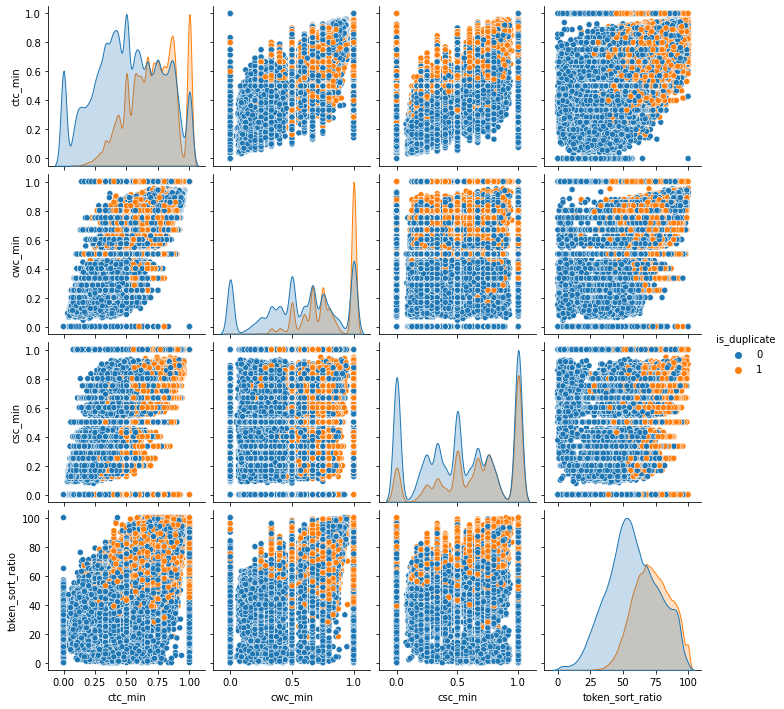

In [25]:
# n=df.shape[0]
# sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue = 'is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']])
# plt.show()
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



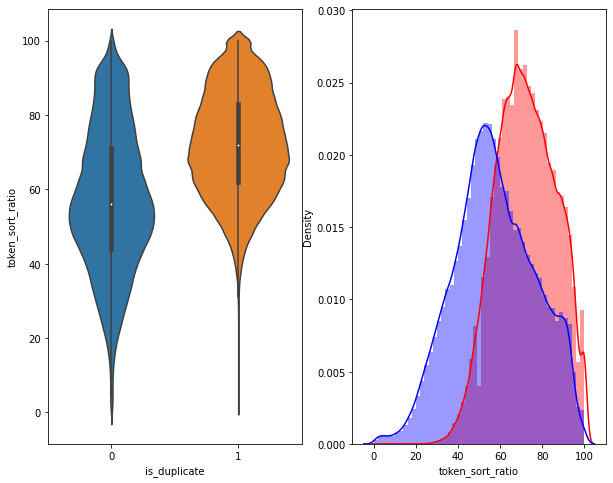

In [26]:
# Distribution of token_sort_ratio
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.violinplot(x="is_duplicate", y='token_sort_ratio', data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [27]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,92,92,100,0.982143
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,65,67,71,0.571429
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,0.599988,0.499992,0.399992,0.249997,0.499995,0.357140,0.0,1.0,4.0,12.0,72,64,39,38,0.185185
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,31,27,22,27,0.045455
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,68,50,36,54,0.157895


In [28]:
from sklearn.preprocessing import MinMaxScaler

df_subsampled = df[:5000]
X = MinMaxScaler().fit_transform(df_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
Y = df_subsampled['is_duplicate']

In [29]:
from sklearn.manifold import TSNE
tsne2d = TSNE(n_components=2,  perplexity=30.0, random_state=101, verbose=2).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.342s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130197
[t-SNE] Computed conditional probabilities in 0.259s
[t-SNE] Iteration 50: error = 81.9585266, gradient norm = 0.0421856 (50 iterations in 2.750s)
[t-SNE] Iteration 100: error = 70.8287277, gradient norm = 0.0096711 (50 iterations in 1.840s)
[t-SNE] Iteration 150: error = 68.8459015, gradient norm = 0.0057419 (50 iterations in 1.749s)
[t-SNE] Iteration 200: error = 67.9481888, gradient norm = 0.0044883 (50 iterations in 1.795s)
[t-SNE] Iteration 250: error = 67.4220047, gradient norm = 0.0039426

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



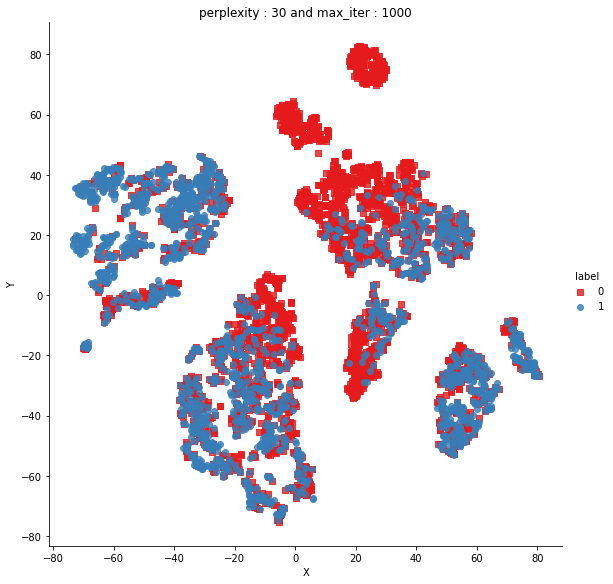

In [30]:
df1 = pd.DataFrame({'X': tsne2d[:,0], 'Y':tsne2d[:,1], "label": Y})
sns.lmplot(data=df1, x="X", y="Y", hue="label", palette="Set1", fit_reg=False, size=8, markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [31]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.349s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130197
[t-SNE] Computed conditional probabilities in 0.249s
[t-SNE] Iteration 50: error = 80.3136292, gradient norm = 0.0306750 (50 iterations in 10.310s)
[t-SNE] Iteration 100: error = 69.3072586, gradient norm = 0.0037575 (50 iterations in 4.760s)
[t-SNE] Iteration 150: error = 67.8670349, gradient norm = 0.0019922 (50 iterations in 4.433s)
[t-SNE] Iteration 200: error = 67.2902603, gradient norm = 0.0013122 (50 iterations in 4.509s)
[t-SNE] Iteration 250: error = 66.9582062, gradient norm = 0.000976

In [32]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = Y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')
plt.show()

## Featurizing text data with tfidf weighted word vectors

In [33]:
!pip install spacy

In [34]:
df['question1'] = df['question1'].apply(lambda x : str(x))
df['question2'] = df['question2'].apply(lambda x : str(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,92,92,100,0.982143
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,65,67,71,0.571429
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,0.599988,0.499992,0.399992,0.249997,0.499995,0.357140,0.0,1.0,4.0,12.0,72,64,39,38,0.185185
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,31,27,22,27,0.045455
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,68,50,36,54,0.157895


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
questions = list(df['question1'])+list(df['question2'])    # Merging texts

tfidf = TfidfVectorizer()    # initialize tfidf vectorizer
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))


In [36]:
len(word2tfidf.keys())

65576

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [37]:
!python -m spacy download en_core_web_lg
!python -m spacy download en
import spacy.cli

spacy.cli.download("en_core_web_lg")

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=73d6ae133d9100a8520d58bbb359dabc61c08f9babc5cdf759c4ccaee4597f2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-hnijdal2/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
     |████████████████████████████████| 12.0 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [38]:
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_lg')
vecs1=[]

for qu1 in tqdm(list(df['question1'])):
  doc1 = nlp(qu1)
  mean_vec1 = np.zeros([len(doc1), len(doc1.vector)])
  for word1 in doc1:
    vec1 = word1.vector
    try:
      idf = word2tfidf[str(word1)]
    except:
      idf = 0

    mean_vec1 += vec1*idf
  mean_vec1 = mean_vec1.mean(axis=0)
  vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)
df.head()

  1%|          | 3301/404290 [00:51<1:06:10, 101.00it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning:

invalid value encountered in true_divide

100%|██████████| 404290/404290 [1:09:35<00:00, 96.82it/s]


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,92,92,100,0.982143,"[-2.762939654290676, 13.306424140930176, 2.928..."
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,65,67,71,0.571429,"[12.696501947939396, 12.233203530311584, 17.19..."
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,0.599988,0.499992,0.399992,0.249997,0.499995,0.357140,0.0,1.0,4.0,12.0,72,64,39,38,0.185185,"[7.553361147642136, 11.738706767559052, -9.742..."
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,31,27,22,27,0.045455,"[1.1108752158470452, 4.3117823004722595, -4.62..."
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,68,50,36,54,0.157895,"[-1.6337312459945679, 10.709765374660492, 13.1..."


In [39]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,92,92,100,0.982143,"[-2.762939654290676, 13.306424140930176, 2.928..."
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,65,67,71,0.571429,"[12.696501947939396, 12.233203530311584, 17.19..."
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,0.599988,0.499992,0.399992,0.249997,0.499995,0.357140,0.0,1.0,4.0,12.0,72,64,39,38,0.185185,"[7.553361147642136, 11.738706767559052, -9.742..."
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,31,27,22,27,0.045455,"[1.1108752158470452, 4.3117823004722595, -4.62..."
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,68,50,36,54,0.157895,"[-1.6337312459945679, 10.709765374660492, 13.1..."


In [40]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2.vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [1:10:29<00:00, 95.58it/s]


In [41]:
from pathlib import Path  
filepath = Path('/content/drive/MyDrive/ML Datasets/CaseStudy1 - Quora/updated.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath, index=False)

In [42]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,92,92,100,0.982143,"[-2.762939654290676, 13.306424140930176, 2.928...","[0.8983361050486565, 10.978307247161865, -0.54..."
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,65,67,71,0.571429,"[12.696501947939396, 12.233203530311584, 17.19...","[7.933836183510721, 10.436825330369174, 16.179..."
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,0.599988,0.499992,0.399992,0.249997,0.499995,0.357140,0.0,1.0,4.0,12.0,72,64,39,38,0.185185,"[7.553361147642136, 11.738706767559052, -9.742...","[-7.24519470334053, 11.065102487802505, -11.64..."
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,31,27,22,27,0.045455,"[1.1108752158470452, 4.3117823004722595, -4.62...","[-2.430336654186249, 32.114163249731064, 22.34..."
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,68,50,36,54,0.157895,"[-1.6337312459945679, 10.709765374660492, 13.1...","[-1.5512511432170868, 1.502782255411148, 1.536..."
